In [ ]:
# !rm -r /content/untitled_project

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
data_directory = "/content/drive/MyDrive/chest_x_ray"

In [ ]:
data_generator = ImageDataGenerator(validation_split=0.2,
                                    rescale=1.0 / 255.0,
                                    zoom_range=0.2,
                                    rotation_range=15,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    horizontal_flip=True,
                                    vertical_flip=False)

# Augmentations

In [ ]:
train_generator = data_generator.flow_from_directory(data_directory,
                                                     target_size=(64, 64),
                                                     class_mode='categorical',
                                                     subset="training")

Found 4686 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# "Dropout"

In [ ]:
model = Sequential()

In [ ]:
model.add(
    Conv2D(filters=16,
           kernel_size=(3, 3),
           activation="relu",
           input_shape=(64, 64, 3)))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

In [ ]:
model.add(Flatten())

model.add(Dense(units=64, activation="relu"))

model.add(Dropout(0.2))

model.add(Dense(units=128, activation="relu"))

model.add(Dense(units=2, activation="softmax"))

In [ ]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 62, 62, 16)        448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 31, 31, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 29, 29, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 6272)              0         
                                                                 
 dense_3 (Dense)             (None, 64)               

In [ ]:
history = model.fit(train_generator, epochs=5)

Epoch 1/10
147/147 [==============================] - 51s 334ms/step - loss: 0.5090 - accuracy: 0.7682
Epoch 2/10
147/147 [==============================] - 49s 336ms/step - loss: 0.3334 - accuracy: 0.8525
Epoch 3/10
147/147 [==============================] - 49s 334ms/step - loss: 0.2845 - accuracy: 0.8801
Epoch 4/10
147/147 [==============================] - 49s 331ms/step - loss: 0.2852 - accuracy: 0.8752
Epoch 5/10
147/147 [==============================] - 49s 333ms/step - loss: 0.2422 - accuracy: 0.9080
Epoch 6/10
147/147 [==============================] - 49s 333ms/step - loss: 0.2361 - accuracy: 0.9052
Epoch 7/10
147/147 [==============================] - 49s 333ms/step - loss: 0.2349 - accuracy: 0.9059
Epoch 8/10
147/147 [==============================] - 49s 333ms/step - loss: 0.2274 - accuracy: 0.9099
Epoch 9/10
147/147 [==============================] - 49s 333ms/step - loss: 0.2093 - accuracy: 0.9195
Epoch 10/10
147/147 [==============================] - 49s 332ms/step - l

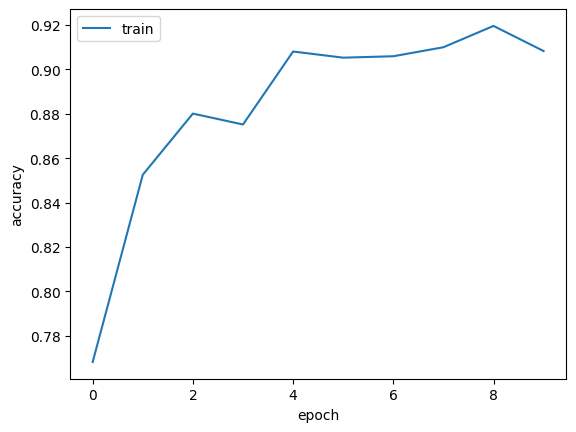

In [ ]:
plt.plot(history.history['accuracy'])

plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.legend(['train'], loc='upper left')

In [ ]:
val_generator = data_generator.flow_from_directory(data_directory,
                                                   target_size=(64, 64),
                                                   class_mode='categorical',
                                                   subset="validation")

Found 1170 images belonging to 2 classes.


In [ ]:
score = model.evaluate(val_generator)

37/37 [==============================] - 12s 327ms/step - loss: 0.2516 - accuracy: 0.8949


In [ ]:
"Test Loss: " + str(score[0])

'Test Loss: 0.25163885951042175'

In [ ]:
"Test Accuracy: " + str(score[1])

'Test Accuracy: 0.8948717713356018'

## Hyperparameter Tuning

In [ ]:
!pip3 install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 3.7 MB/s eta 0:00:00


In [ ]:
import keras
import keras_tuner

from tensorflow.keras.layers import BatchNormalization

In [ ]:
def build_model(hp):
    model = Sequential()

    num_conv_layers = hp.Int('num_conv_layers',
                             min_value=1,
                             max_value=5,
                             step=1)
    num_dense_layers = hp.Int('num_dense_layers',
                              min_value=1,
                              max_value=5,
                              step=1)

    model.add(
        Conv2D(filters=hp.Int('filters_initial',
                              min_value=16,
                              max_value=512,
                              step=16),
               kernel_size=(3, 3),
               activation=hp.Choice("activation_initial",
                                    values=["relu", "leaky_relu"]),
               padding="same",
               input_shape=(64, 64, 3)))
    if hp.Boolean(f"use_batchnorm_conv_initial"):
            model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))

    for i in range(num_conv_layers):
        model.add(
            Conv2D(filters=hp.Int(f'filters_conv_{i}',
                                  min_value=16,
                                  max_value=512,
                                  step=16),
                   kernel_size=(3, 3),
                   activation=hp.Choice(f"activation_conv_{i}",
                                        values=["relu", "leaky_relu"]),
                   padding="same"))
        if hp.Boolean(f"use_batchnorm_conv_{i}"):
            model.add(BatchNormalization())
        model.add(MaxPooling2D(2, 2))

    model.add(Flatten())

    for i in range(num_dense_layers):
        if hp.Boolean(f"use_dropout_dense_{i}"):
            model.add(
                Dropout(
                    hp.Float(f"dropout_dense_{i}",
                             min_value=0,
                             max_value=1,
                             step=0.05)))

        model.add(
            Dense(units=hp.Int(f"units_dense_{i}",
                               min_value=16,
                               max_value=512,
                               step=16),
                  activation=hp.Choice(f"activation_dense_{i}",
                                       values=["relu", "leaky_relu"])))

        if hp.Boolean(f"use_batchnorm_dense_{i}"):
            model.add(BatchNormalization())

    model.add(Dense(units=2, activation="softmax"))

    model.compile(optimizer=hp.Choice("optimizer", values=["adam", "rmsprop"]),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

    return model

In [ ]:
build_model(keras_tuner.HyperParameters())

In [ ]:
tuner = keras_tuner.Hyperband(build_model,
                              max_epochs=10,
                              objective="val_accuracy")

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 13
num_conv_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
num_dense_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
filters_initial (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 512, 'step': 16, 'sampling': 'linear'}
activation_initial (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'leaky_relu'], 'ordered': False}
use_batchnorm_conv_initial (Boolean)
{'default': False, 'conditions': []}
filters_conv_0 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 512, 'step': 16, 'sampling': 'linear'}
activation_conv_0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'leaky_relu'], 'ordered': False}
use_batchnorm_conv_0 (Boolean)
{'default': False, 'conditions': []}
use_dropout_dense_0 (Boolean)
{'default': False, 'conditions': []}
units

In [ ]:
tuner.search(x=train_generator, validation_data=val_generator)

Trial 30 Complete [00h 13m 02s]
val_accuracy: 0.879487156867981

Best val_accuracy So Far: 0.9196581244468689
Total elapsed time: 02h 48m 59s


In [ ]:
best_model = tuner.get_best_models()[0]

In [ ]:
image = load_img("/content/person1_bacteria_2.jpeg",
                 target_size=(64, 64))

In [ ]:
image_array = img_to_array(image)

In [ ]:
image_array = image_array.reshape((1, ) + image_array.shape)

In [ ]:
image_array = image_array / 255.0

In [ ]:
prediction = best_model.predict(image_array)

1/1 [==============================] - 0s 193ms/step


In [ ]:
prediction

array([[0.15624544, 0.8437546 ]], dtype=float32)

In [ ]:
class_names = ["normal", "pneumonia"]

In [ ]:
class_names[np.argmax(prediction[0])]

'pneumonia'

In [ ]:
best_model.save('x-ray_best_model.keras')